In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pvwatts_file = "input/pvwatts_hourly.csv"
load_file = "input/My Project - hourly (baseline).csv"

# Start with PVWatts data
# PVWatts has the real header at row 32 (0-indexed row 31 in pandas)
pv = pd.read_csv(pvwatts_file, skiprows=31)

# Required PVWatts columns: Month, Day, Hour, AC System Output (W)
pv = pv[['Month', 'Day', 'Hour', 'AC System Output (W)']]

# PVWatts “Hour” is 0–23; build datetime assuming one calendar year
YEAR = 2025
pv['timestamp'] = pd.to_datetime({
    'year': YEAR,
    'month': pv['Month'],
    'day': pv['Day'],
    'hour': pv['Hour']
})

# Convert solar output to kW
pv['solar_kw'] = pv['AC System Output (W)'] / 1000

pv = pv[['timestamp', 'solar_kw']]

print(pv.head(18))

             timestamp   solar_kw
0  2025-01-01 00:00:00   0.000000
1  2025-01-01 01:00:00   0.000000
2  2025-01-01 02:00:00   0.000000
3  2025-01-01 03:00:00   0.000000
4  2025-01-01 04:00:00   0.000000
5  2025-01-01 05:00:00   0.000000
6  2025-01-01 06:00:00   0.000000
7  2025-01-01 07:00:00   0.000000
8  2025-01-01 08:00:00   0.395423
9  2025-01-01 09:00:00   4.760728
10 2025-01-01 10:00:00  20.060879
11 2025-01-01 11:00:00  22.773591
12 2025-01-01 12:00:00  35.604117
13 2025-01-01 13:00:00  33.723396
14 2025-01-01 14:00:00  30.089134
15 2025-01-01 15:00:00  18.317589
16 2025-01-01 16:00:00   5.396013
17 2025-01-01 17:00:00   0.000000


In [33]:
# Read hourly load data
# Load file has normal headers in row 1
load = pd.read_csv(load_file)
load['load_kw'] = load['electric']
load = load[['load_kw']]

df = pv.join(load)
df['net_solar_kw'] = (df['solar_kw'] - df['load_kw']).clip(lower=0)
df['date'] = df['timestamp'].dt.date

print(df.head(18))

# Identify key days
daily = df.groupby('date').agg(
    daily_load=('load_kw', 'sum'),
    daily_solar=('solar_kw', 'sum'),
    daily_net=('net_solar_kw', 'sum')
)

daily


             timestamp   solar_kw  load_kw  net_solar_kw        date
0  2025-01-01 00:00:00   0.000000    16.11      0.000000  2025-01-01
1  2025-01-01 01:00:00   0.000000    15.09      0.000000  2025-01-01
2  2025-01-01 02:00:00   0.000000    15.10      0.000000  2025-01-01
3  2025-01-01 03:00:00   0.000000    15.10      0.000000  2025-01-01
4  2025-01-01 04:00:00   0.000000    17.90      0.000000  2025-01-01
5  2025-01-01 05:00:00   0.000000    23.16      0.000000  2025-01-01
6  2025-01-01 06:00:00   0.000000    22.50      0.000000  2025-01-01
7  2025-01-01 07:00:00   0.000000    23.51      0.000000  2025-01-01
8  2025-01-01 08:00:00   0.395423    17.58      0.000000  2025-01-01
9  2025-01-01 09:00:00   4.760728    14.80      0.000000  2025-01-01
10 2025-01-01 10:00:00  20.060879    14.79      5.270879  2025-01-01
11 2025-01-01 11:00:00  22.773591    14.78      7.993591  2025-01-01
12 2025-01-01 12:00:00  35.604117    14.79     20.814117  2025-01-01
13 2025-01-01 13:00:00  33.723396 

,daily_load,daily_solar,daily_net
date,,,
2025-01-01,545.78,171.120870,69.028706
2025-01-02,545.97,14.147064,0.000000
2025-01-03,545.23,59.258936,0.000000
2025-01-04,544.69,60.905972,0.000000
2025-01-05,544.83,33.231926,0.000000
...,...,...,...
2025-12-27,545.13,274.786197,158.354854
2025-12-28,544.55,176.520226,62.464271
2025-12-29,545.46,36.154094,0.000000


Day with highest load: 2025-08-27
Day with highest solar: 2025-05-22
Day with highest net solar: 2025-03-22


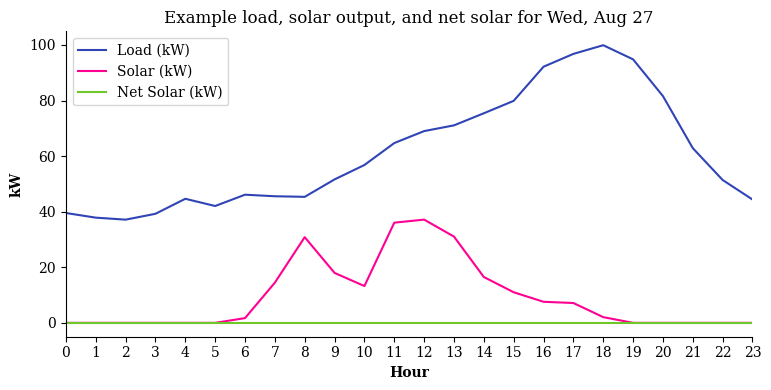

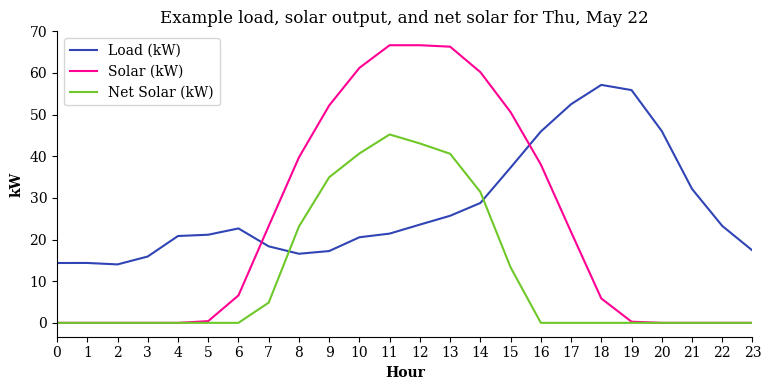

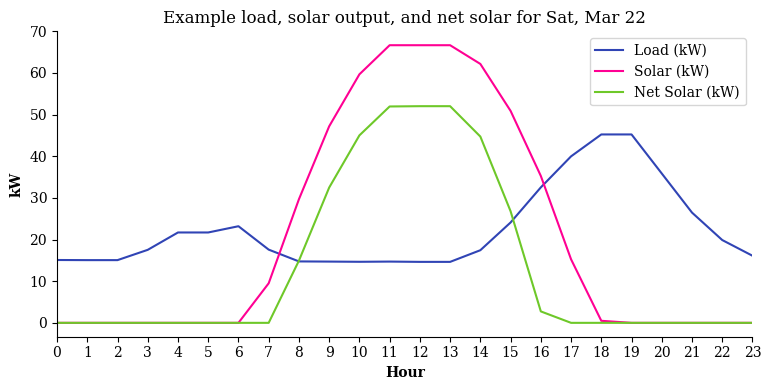

In [58]:
# Start plotting
# Use the UCS style if it's installed
try:
    import UCSmpl
    style_name = 'ucs_light'
except ImportError:
    style_name = 'default'

# Function to plot a single day
def plot_day(df, day, title):
    day_df = df[df['date'] == day]

    with plt.style.context(style_name):
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(day_df['timestamp'], day_df['load_kw'], label='Load (kW)')
        ax.plot(day_df['timestamp'], day_df['solar_kw'], label='Solar (kW)')
        ax.plot(day_df['timestamp'], day_df['net_solar_kw'], label='Net Solar (kW)')
        ax.set_title(title)
        ax.set_xlabel("Hour")
        ax.set_ylabel("kW")
        ax.legend()
        plt.tight_layout()

        # Show only hours on x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%#H'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.set_xlim(day_df['timestamp'].iloc[0], day_df['timestamp'].iloc[-1])
        plt.show()


# Identify some interesting days to plot
day_high_load = daily['daily_load'].idxmax()
day_high_solar = daily['daily_solar'].idxmax()
day_high_net = daily['daily_net'].idxmax()

print("Day with highest load:", day_high_load)
print("Day with highest solar:", day_high_solar)
print("Day with highest net solar:", day_high_net)

# Plot the three requested days
plot_day(df, day_high_load, f"Example load, solar output, and net solar for {day_high_load.strftime('%a, %b %d')}")
plot_day(df, day_high_solar, f"Example load, solar output, and net solar for {day_high_solar.strftime('%a, %b %d')}")
plot_day(df, day_high_net, f"Example load, solar output, and net solar for {day_high_net.strftime('%a, %b %d')}")

In [59]:
df[df['date'] == day_high_net]

,timestamp,solar_kw,load_kw,net_solar_kw,date
1920,2025-03-22 00:00:00,0.000000,15.09,0.000000,2025-03-22
1921,2025-03-22 01:00:00,0.000000,15.06,0.000000,2025-03-22
1922,2025-03-22 02:00:00,0.000000,15.06,0.000000,2025-03-22
1923,2025-03-22 03:00:00,0.000000,17.53,0.000000,2025-03-22
1924,2025-03-22 04:00:00,0.000000,21.70,0.000000,2025-03-22
1925,2025-03-22 05:00:00,0.000000,21.70,0.000000,2025-03-22
1926,2025-03-22 06:00:00,0.000000,23.20,0.000000,2025-03-22
1927,2025-03-22 07:00:00,9.501356,17.58,0.000000,2025-03-22
1928,2025-03-22 08:00:00,29.684561,14.75,14.934561,2025-03-22
1929,2025-03-22 09:00:00,47.191212,14.71,32.481212,2025-03-22
